In [2]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from data import MyData
from model import MyLSTM,MyModel
from torch.utils.data import DataLoader
import matplotlib.pyplot  as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

mycolors = plt.cm.RdBu(list(range(0,256,256//10)))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)

In [4]:
batch_size = 15000

setup_seed(10086)
traindata = MyData(data_path='./data/TrainData.json',l=4,frac=1)
valdata = MyData(data_path='./data/TestData.json',l=4)

train_dataloader = DataLoader(traindata, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(valdata, batch_size=batch_size, shuffle=False)

model = MyModel(hidden_size=128,name=f'Model').to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# 定义余弦退火调度器
num_epochs = 10
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

# 进行模型训练
epochs = 100
best_rmse = 1
for epoch in range(epochs):
    model.train()
    print(f'==========Epoch {epoch}==========')
    for idx, batch in enumerate(train_dataloader):
        X, y, last, _ = batch
        X = X.to(device)
        y = y.to(device)

        # 前向传播和计算损失
        optimizer.zero_grad()
        outputs = model(X, last)
        loss = criterion(outputs, y)
        # print(f'{idx}, Loss: {loss.item()}')

        # 反向传播和参数更新
        loss.backward()
        optimizer.step()
        scheduler.step()

    for idx, batch in enumerate(val_dataloader):
        X, y, last, _ = batch
        X = X.to(device)
        y = y.to(device)
        outputs = model(X, last)
        loss = criterion(outputs, y)
        RMSE = torch.sqrt(torch.mean(torch.sum(torch.square(outputs[:,:2]-y[:,:2]),dim=1)))

        if best_rmse >  RMSE:
            best_rmse = RMSE
            print('Test Best RMSE',RMSE.item())
            model.save(f'best.pth')

加载数据，总共有 436 个台风， 12839 条台风数据
总共生成 11095 个序列
加载数据，总共有 152 个台风， 4539 条台风数据
总共生成 393 个序列
==========Epoch 0==========


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_mm)

In [2]:
testdata = MyData(data_path='./data/TestData.json',l=4,frac=1)
batch_size = 4096
RMSE = {}

GT_Predict = pd.DataFrame(np.full([len(testdata), 5],np.nan),columns=['True_lat','True_lon','Predict_lat','Predict_lon','SE'])

model = MyLSTM().to(device)
model.load_state_dict(torch.load(f'checkpoints/24h/best.pth'))
test_dataloader = DataLoader(testdata, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

for i ,batch in enumerate(test_dataloader):
    X, y, last, _ = batch

    predict_y = testdata.inverse_norm(model(X.to(device), last).cpu().detach()).numpy()
    true_y = testdata.inverse_norm(y).numpy()
GT_Predict.iloc[:, :2] = true_y[:,:2]*0.1

GT_Predict.iloc[:, 2:4] = predict_y[:,:2]*0.1
GT_Predict.iloc[:, 4] = np.sum(np.square(GT_Predict.iloc[:, :2].values - GT_Predict.iloc[:, 2:4].values), axis=1)

GT_Predict.to_csv(f'checkpoints/24h/TestPredict.csv')
RMSE[f'24h'] = np.sqrt(np.mean(GT_Predict['SE'].values))
RMSE

加载数据，总共有 152 个台风， 4539 条台风数据
总共生成 3931 个序列


RuntimeError: Error(s) in loading state_dict for MyLSTM:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([512, 4]) from checkpoint, the shape in current model is torch.Size([1024, 4]).
	size mismatch for lstm.weight_hh_l0: copying a param with shape torch.Size([512, 128]) from checkpoint, the shape in current model is torch.Size([1024, 256]).
	size mismatch for lstm.bias_ih_l0: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for lstm.bias_hh_l0: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for mlp.0.weight: copying a param with shape torch.Size([1024, 128]) from checkpoint, the shape in current model is torch.Size([1024, 256]).

In [6]:
testdata = MyData(data_path='./data/TestData.json',l=4,frac=1,TaifengID=19)
batch_size = 4096
RMSE = {}

GT_Predict = pd.DataFrame(np.full([len(testdata), 5],np.nan),columns=['True_lat','True_lon','Predict_lat','Predict_lon','SE'])

model = MyLSTM().to(device)
model.load_state_dict(torch.load(f'checkpoints/24h/best.pth'))
test_dataloader = DataLoader(testdata, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

for i ,batch in enumerate(test_dataloader):
    X, y, last, _ = batch
    model.eval()
    predict_y = testdata.inverse_norm(model(X.to(device), last).cpu().detach()).numpy()
    true_y = testdata.inverse_norm(y).numpy()
GT_Predict.iloc[:, :2] = true_y[:,:2]*0.1

GT_Predict.iloc[:, 2:4] = predict_y[:,:2]*0.1
GT_Predict.iloc[:, 4] = np.sum(np.square(GT_Predict.iloc[:, :2].values - GT_Predict.iloc[:, 2:4].values), axis=1)

# GT_Predict.to_csv(f'checkpoints/24h/TestPredict.csv')
RMSE[f'24h'] = np.sqrt(np.mean(GT_Predict['SE'].values))
RMSE

加载数据，总共有 152 个台风， 4539 条台风数据
总共生成 42 个序列


RuntimeError: Error(s) in loading state_dict for MyLSTM:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([512, 4]) from checkpoint, the shape in current model is torch.Size([1024, 4]).
	size mismatch for lstm.weight_hh_l0: copying a param with shape torch.Size([512, 128]) from checkpoint, the shape in current model is torch.Size([1024, 256]).
	size mismatch for lstm.bias_ih_l0: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for lstm.bias_hh_l0: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for mlp.0.weight: copying a param with shape torch.Size([1024, 128]) from checkpoint, the shape in current model is torch.Size([1024, 256]).

In [6]:
from torch.nn.utils.rnn import pad_packed_sequence
testdata.inverse_norm(pad_packed_sequence(X, batch_first=True)[0][-4])

tensor([[ 343., 1281.,  975.,   33.],
        [ 359., 1310.,  990.,   25.],
        [ 384., 1361.,  995.,   20.],
        [ 400., 1430.,  995.,   20.]])

In [7]:
print(GT_Predict)

     True_lat    True_lon  Predict_lat  Predict_lon         SE
0   15.800000  156.199997    16.475653   157.120850   1.304476
1   15.300000  154.699997    16.479528   155.970200   3.004702
2   14.700000  153.400009    16.216152   154.651489   3.864920
3   14.500000  152.100006    15.762942   153.367172   3.200733
4   14.500000  150.900009    15.422167   152.059616   2.195080
5   14.400001  150.000000    15.239635   150.767014   1.293295
6   14.400001  148.400009    15.051294   149.386108   1.396575
7   14.500000  146.900009    15.000218   148.258484   2.095672
8   14.500000  145.199997    15.062694   147.068161   3.806661
9   14.500000  144.199997    15.126460   145.641098   2.469225
10  14.500000  143.199997    15.163432   144.287857   1.623582
11  14.200000  141.800003    15.192352   143.101181   2.677828
12  13.800000  140.600006    15.033388   141.702286   2.736266
13  13.400001  139.300003    14.775929   140.650375   3.716686
14  13.500000  138.199997    14.411366   139.266815   1

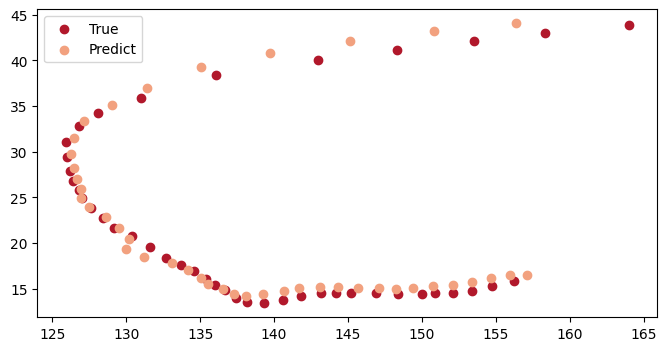

In [8]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
plt.scatter(GT_Predict['True_lon'],GT_Predict['True_lat'],color=mycolors[1])
plt.scatter(GT_Predict['Predict_lon'],GT_Predict['Predict_lat'],color=mycolors[3])
# plt.scatter(y_predict[:,1],y_predict[:,0],color=mycolors[9])
plt.legend(['True','Predict'])
plt.show()